In [1]:
import sys
sys.path.append('../')
from localconfig import BASE_PATH,EXPS

import pathlib
import numpy as np
import matplotlib.pyplot as plt
from scipy import interpolate
np.set_printoptions(threshold=1050)
from pprint import pprint

import maxone_code.data
import maxone_code.fig
from maxone_code.data import Experiment
from maxone_code.artifact.remover import ArtifactAssay

## 計測データの確認
- 計測データ、計測電極、刺激電極を読み込む
- 指定した刺激インターバルから刺激開始フレームを推定。

In [2]:
# EXP,FILE=(EXPS[0],'searching-5764-5764.raw.h5')
# EXP,FILE=(EXPS[2],'searching-984-983.raw.h5')
EXP,FILE=(EXPS[1],'searching-984-984.raw.h5')
path=pathlib.Path(BASE_PATH).joinpath('data',EXP,'raw',FILE)
save_dir=pathlib.Path(BASE_PATH).joinpath('data',EXP,'artifact_removal')
path_cache_data=save_dir.joinpath('data_raw.npy')

In [3]:
# trialあたりにロードするframe数を指定
# trial間隔を超えないように注意
assay=ArtifactAssay(path,lookforframe=1000)

In [4]:
# 刺激開始フレームの表示
assay.exp.disp()

sig shape: (1028, 120200)
record time: 6[s]
record eles_size:  444
trial start frame:  [20389, 40469, 60549, 80629, 100709]
stim interval:  [20080 20080 20080 20080]


### 刺激・計測電極の表示

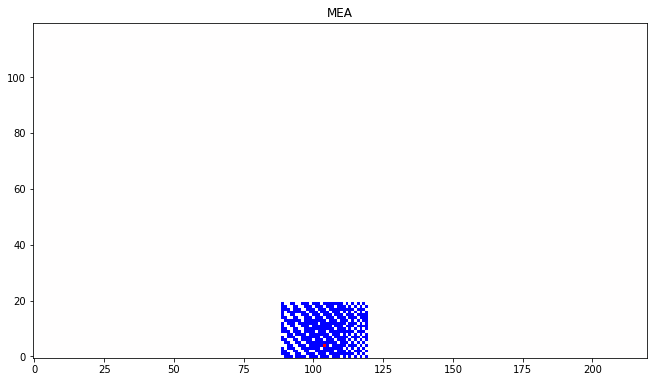

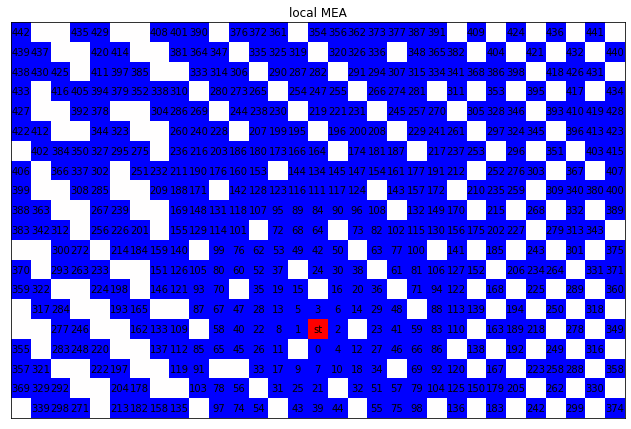

In [5]:
assay.disp_mea()
assay.disp_mea_local()

### 異なるフィルターの適用

In [6]:
# 生データの読み込み
assay.loaddata()

In [7]:
from maxone_code.spikedetect import BandPassFilter,HighPassFilter

bpfs = {
    'BPF 1000': BandPassFilter(lowcut=250, highcut=1000, order=4),
    'BPF 2000': BandPassFilter(lowcut=250, highcut=2000, order=4),
    'BPF 3000': BandPassFilter(lowcut=250, highcut=3000, order=4),
    'BPF 4000': BandPassFilter(lowcut=250, highcut=4000, order=4),
    'BPF 5000': BandPassFilter(lowcut=250, highcut=5000, order=4),
    'HPF': HighPassFilter(lowcut=250,order=4),
    }

In [8]:
bpf=bpfs['HPF']
data_post_butter = assay.filterProccessing(bpf,assay.data_raw_m)
assay.data_filtered_m = data_post_butter
MARGIN = assay.BPF_MARGIN_FRAME
assay.data_filtered = data_post_butter[:, :, MARGIN:-MARGIN]

In [9]:
# アーチファクト除去
# 500点計測,6trial,1000frameで30秒かかる
assay.cleanArtifact()

# 以下のデータが生成される
# - assay.data_raw   :　sigデータ
# - assay.data_filtered   :バンドパスフィルター後
# - assay.artifacts_c   :チャネル間で共通するアーチファクト
# - assay.data_cleaned_c   :チャネル間アーチファクトの除去後
# - assay.artifacts_t   :トライアル間で共通するアーチファクト
# - assay.data_cleaned_t   :トライアル間アーチファクトの除去後
# - assay.data_all_cleaned   :バンドパスフィルター後

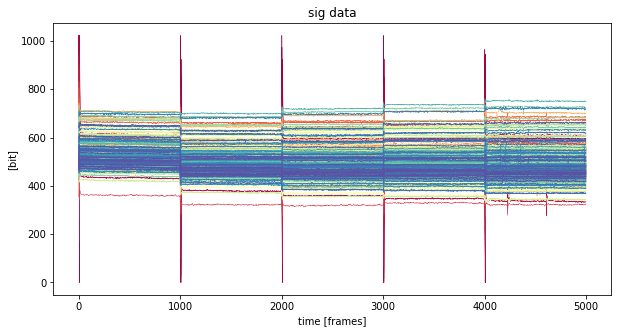

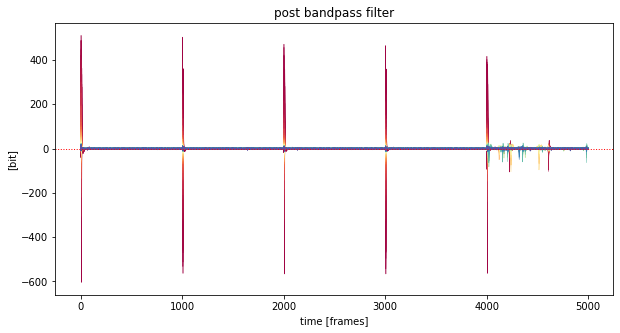

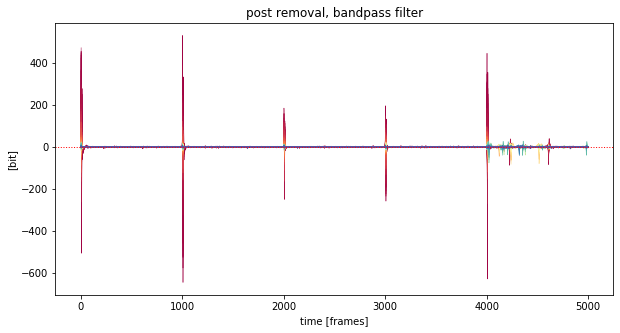

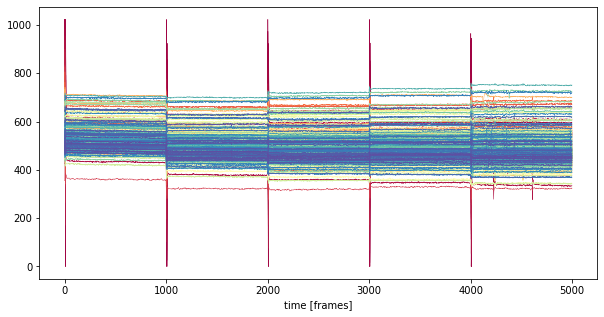

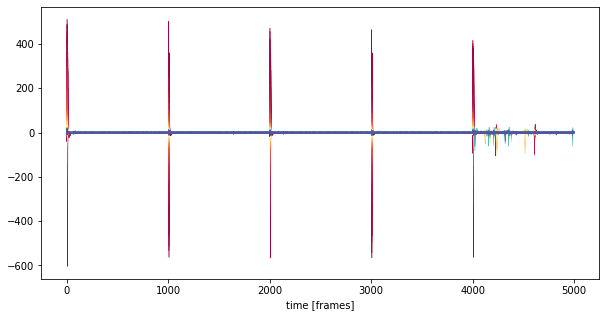

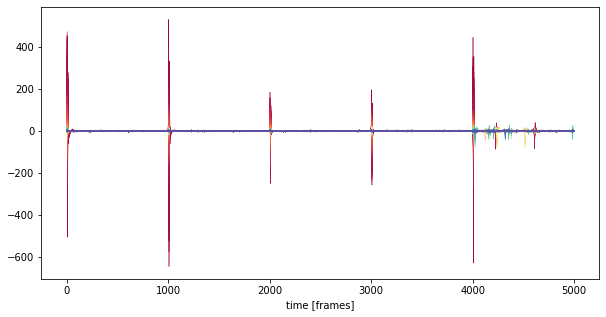

In [10]:
# trialをくっつけてデータを表示
assay.disp_raw()
assay.disp_filtered()
assay.disp_allcleaned()
# これも同じ意味。
assay.disp_data(assay.data_raw)
assay.disp_data(assay.data_filtered)
assay.disp_data(assay.data_all_cleaned)

### disp_*関数のパラメーター
基本的にdisp_*関数には以下の引数が使える。
- isConcat=True : trialをつなげて1つのグラフで表示するか
- ylabel=None : y軸のタイトル
- draw_xaxis=False  : x軸(y=0)を表示するか
- title=None : グラフのタイトル
- trange=None : 表示するtrialを指定 ::= None | int | [int] 
- yrange=None : y軸の幅 ::= [int, int]
- xids=None : 表示するチャネルをxidで指定 ::= None | int | [int] 
- drange=None : (使用頻度小) 表示するチャネルを刺激電極からの距離で指定 ::= [int, int]
- frange=None : 表示するframe数をnp.s_[int:int]で指定
- legend=False : 図の凡例を表示するか
- path=None : グラフを保存する場合のpathを指定


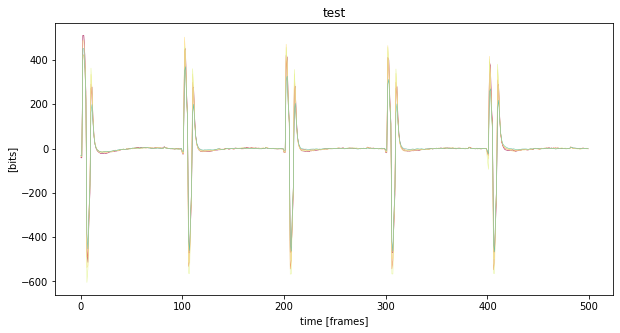

In [11]:
assay.disp_filtered(isConcat=True, ylabel='[bits]', draw_xaxis=False, title='test', 
                    trange=None, yrange=None,drange=None, frange=np.s_[:100], legend=False, xids=np.arange(5), path=None)


## アーチファクトの解析
アーチファクトの除去は2段階
- チャネル間で相関した波形の除去(disp_cleaned_c)
- トライアル間で相関した波形の除去(disp_cleaned_t)
- https://iopscience.iop.org/article/10.1088/1741-2552/aaa365/meta
- 論文では3段階で、もう一つは１刺激のパルス間での波形除去


### スパイクの確認

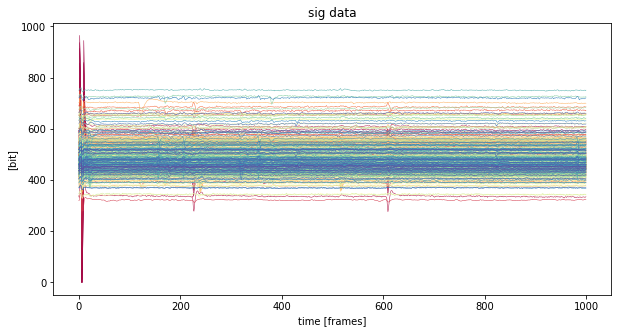

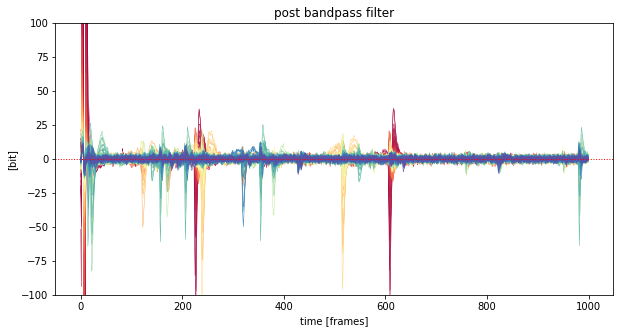

In [12]:
assay.disp_raw(trange=4)
assay.disp_filtered(trange=4, yrange=[-100,100])

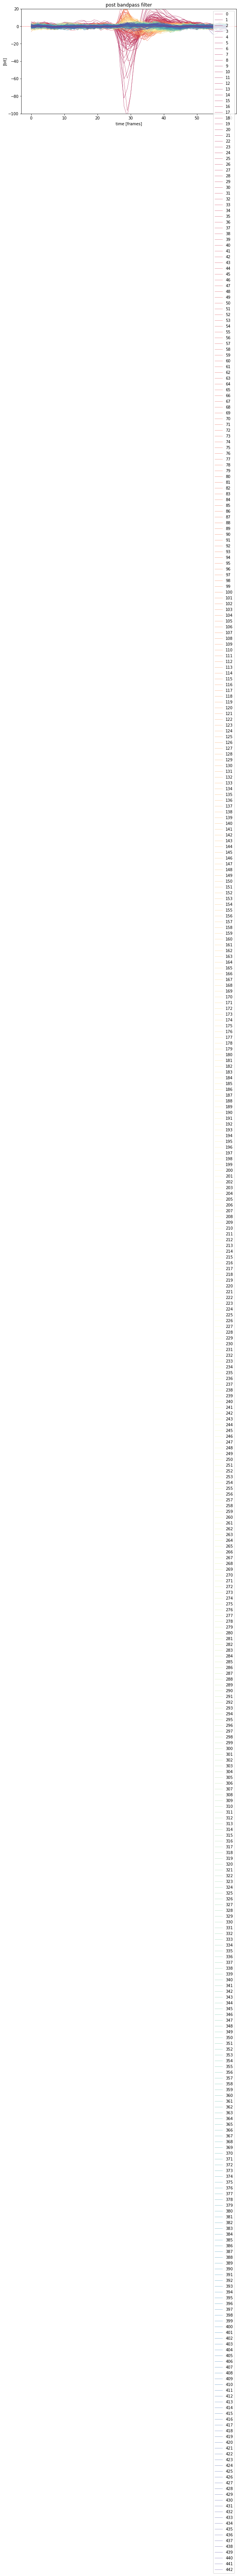

In [13]:
assay.disp_filtered(trange=4, frange=np.s_[20*29:20*32],yrange=[-100,20],legend=True)

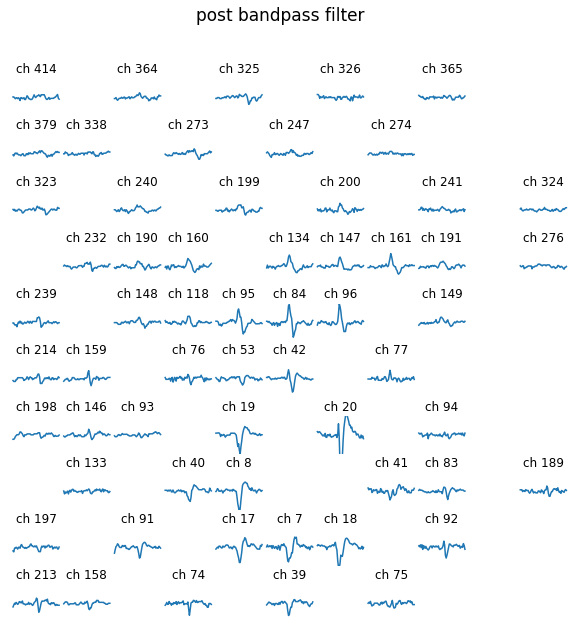

In [14]:
assay.disp_filtered_on_mea(trange=4, frange=np.s_[20*29:20*32],yrange=[-20,20], sp_pattern=(2,(11, 11),None),
                           show_spine=False, isDry=False, hspace=0.5, wspace=0,)

In [15]:
assay.xid2channel_table[199]
# (channel_id, 刺激電極からの距離[um])

(412, 178.46568297574746)

180uMのところまでスパイクが広がっている

### アーチファクトの確認

In [16]:
# 主成分分析する範囲の変更
start_frame=0
stop_frame=300
sel=np.s_[start_frame:stop_frame+1]
assay.cleanArtifact(sel)

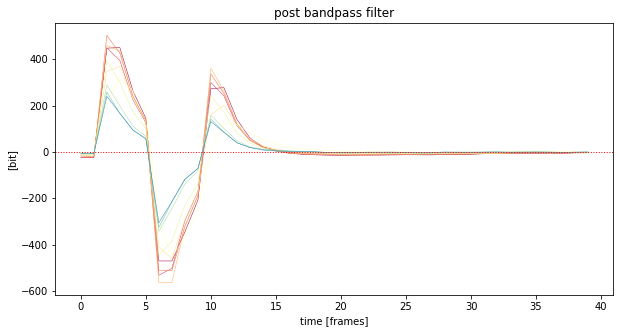

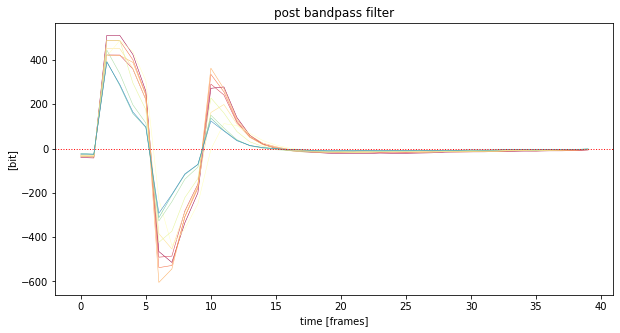

In [17]:

assay.disp_filtered(trange=[1],yrange=None,xids=np.arange(0,10), frange=np.s_[:40])
assay.disp_filtered(trange=[0],yrange=None,xids=np.arange(0,10), frange=np.s_[:40])

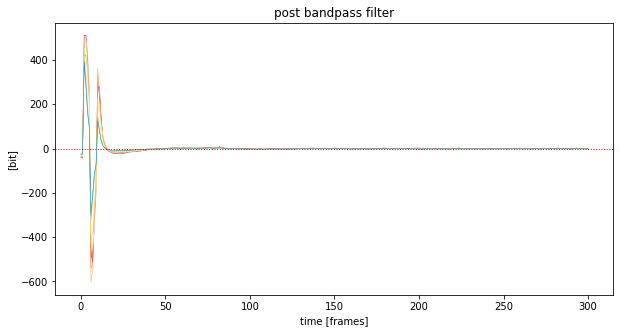

In [18]:

# assay.disp_filtered(trange=[0],yrange=[-20,20], xids=np.arange(10))
assay.disp_filtered(trange=[0],yrange=None, xids=np.arange(10))

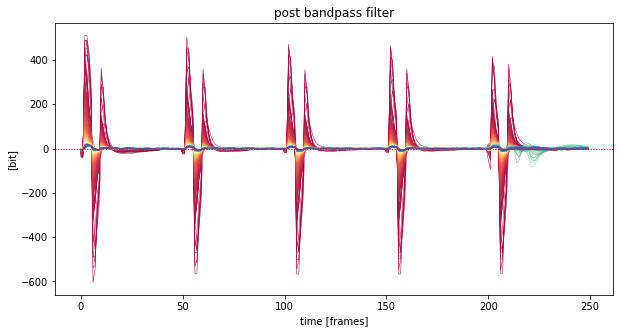

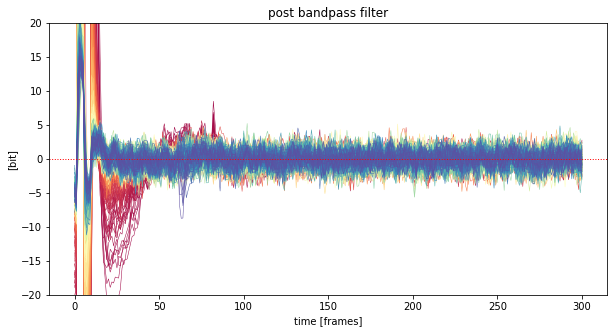

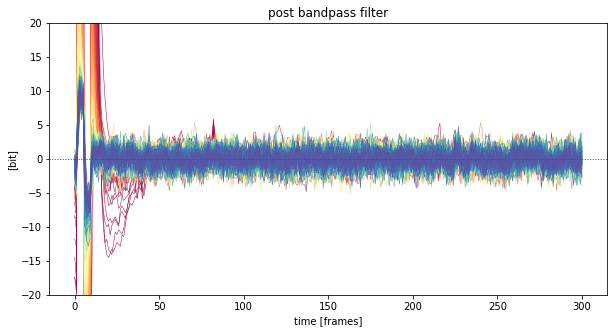

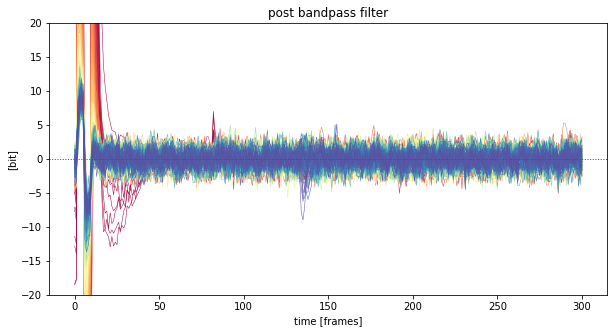

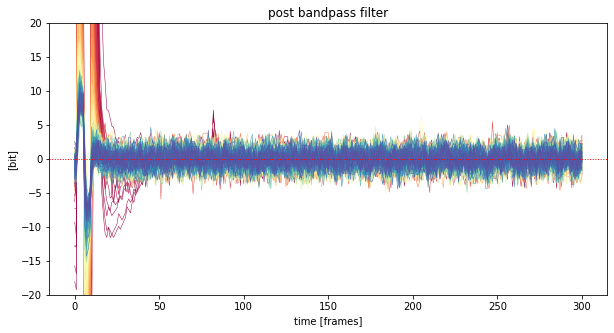

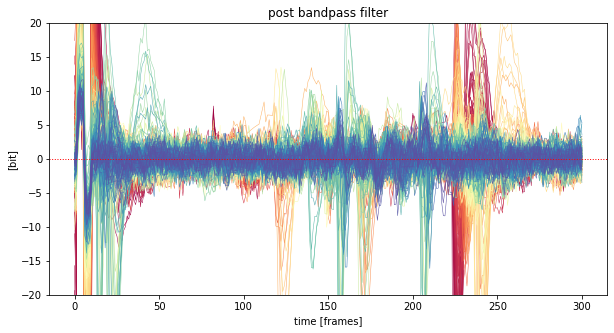

In [19]:
assay.disp_filtered(trange=None, frange=np.s_[:50])
assay.disp_filtered(trange=[0],yrange=[-20,20])
assay.disp_filtered(trange=[1],yrange=[-20,20])
assay.disp_filtered(trange=[2],yrange=[-20,20])
assay.disp_filtered(trange=[3],yrange=[-20,20])
assay.disp_filtered(trange=[4],yrange=[-20,20])

アーチファクトは13frameまでのる

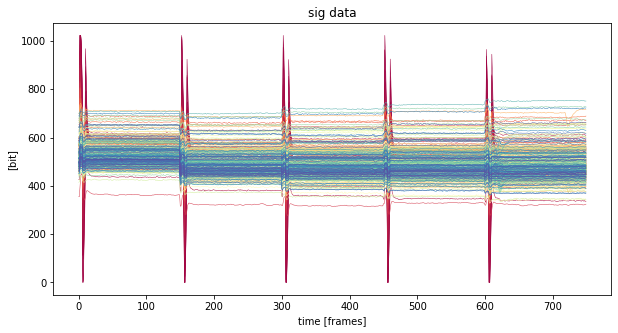

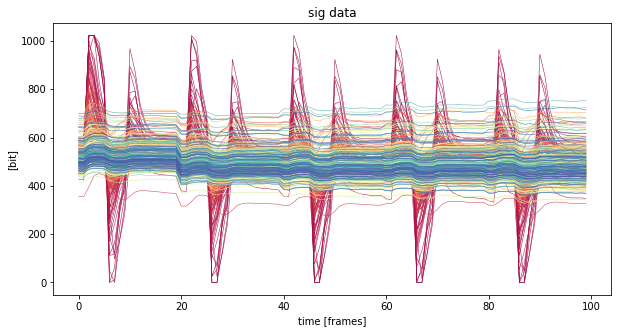

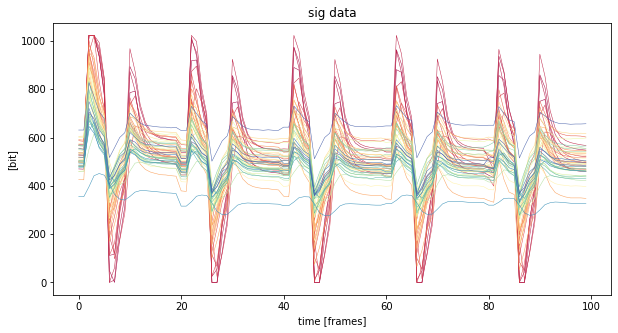

In [20]:
assay.disp_raw(trange=None, frange=np.s_[:150])
assay.disp_raw(trange=None, frange=np.s_[:20])
assay.disp_raw(trange=None, frange=np.s_[:20], xids=np.arange(50))

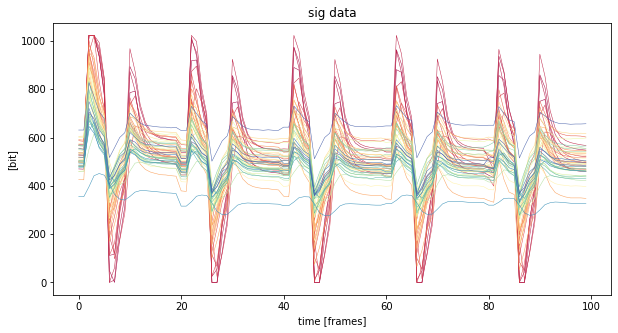

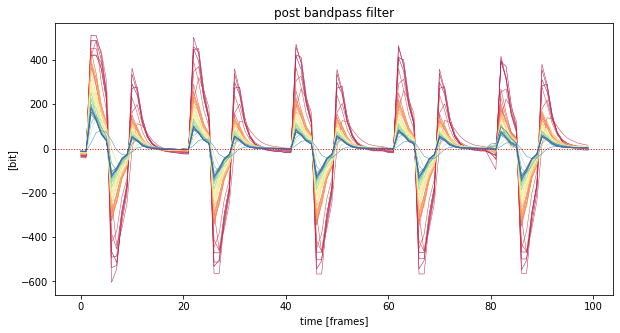

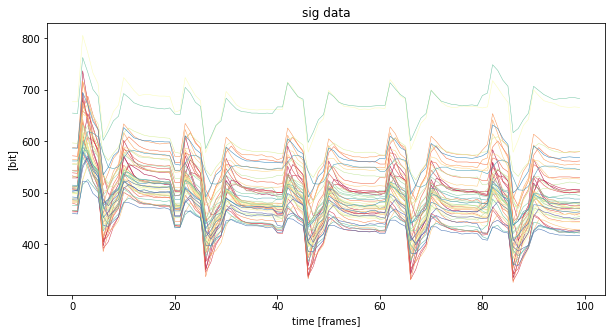

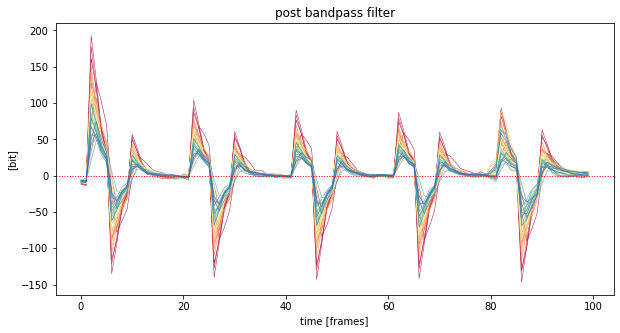

In [21]:
assay.disp_raw(trange=None, frange=np.s_[:20], xids=np.arange(50))
assay.disp_filtered(trange=None, frange=np.s_[:20], xids=np.arange(50))
assay.disp_raw(trange=None, frange=np.s_[:20], xids=np.arange(50,100))
assay.disp_filtered(trange=None, frange=np.s_[:20], xids=np.arange(50,100))

- DAC40だとほぼサチらない
- 一回目の刺激はアーチファクトが大きく出る

### 主成分分析パラメータの設定
以上から
- 周辺電極のスパイクまで削除しないように、除外範囲は180umに設定する
- 刺激後0-5msを主成分分析すればよい


In [22]:
assay2=ArtifactAssay(path,lookforframe=1000)
assay2.loaddata()

In [23]:
# 主成分分析する範囲の変更
start_frame=0
stop_frame=13
sel=np.s_[start_frame:stop_frame+1]
assay2.cleanArtifact(sel, 180)

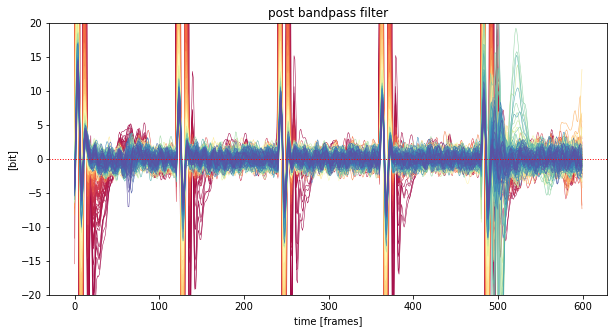

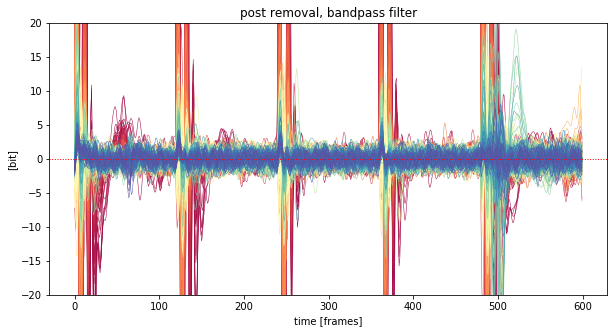

In [24]:
assay2.disp_filtered(yrange=[-20,20], frange=np.s_[:120])
assay2.disp_allcleaned(yrange=[-20,20], frange=np.s_[:120])

### MEA上で活動データを表示

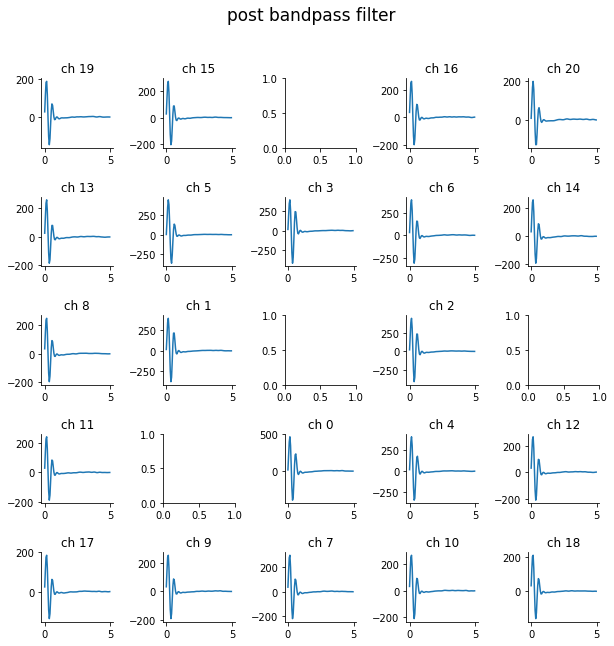

In [25]:
assay2.disp_filtered_on_mea(sp_pattern=-1, frange=np.s_[:100], trange=[0])

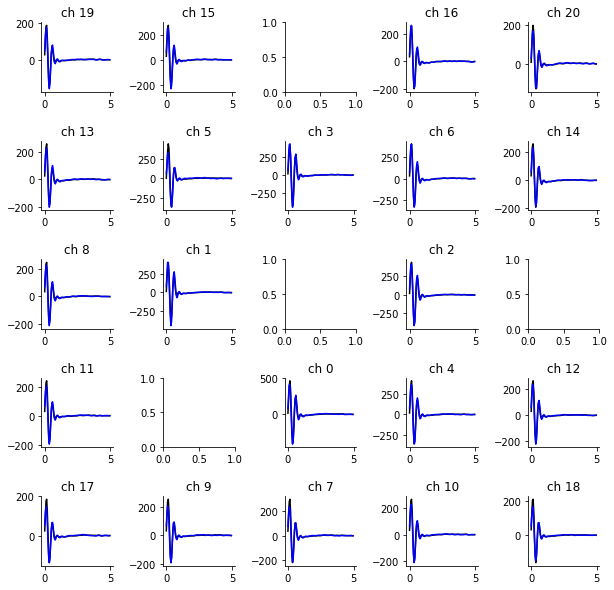

In [26]:
assay2.disp_beforeafter_all(sp_pattern=-1, frange=np.s_[:100], trange=[0])

### パラメータが厳しいとうまくいかない

In [27]:
assay3=ArtifactAssay(path,lookforframe=1000)
assay3.loaddata()
# 主成分分析する範囲の変更
start_frame=0
stop_frame=13
sel=np.s_[start_frame:stop_frame+1]
assay3.cleanArtifact(sel, 20)

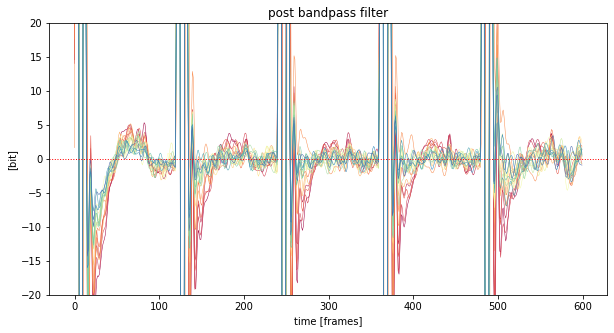

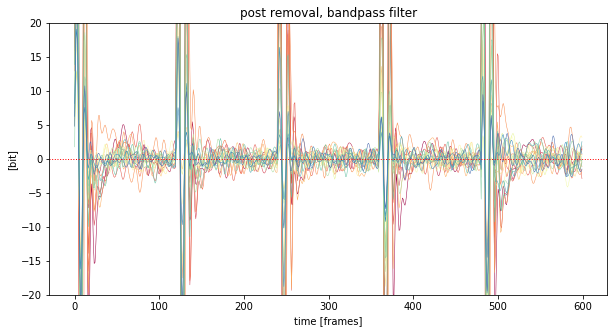

In [28]:
assay3.disp_filtered(yrange=[-20,20], frange=np.s_[:120], xids=np.arange(20))
assay3.disp_allcleaned(yrange=[-20,20], frange=np.s_[:120], xids=np.arange(20))

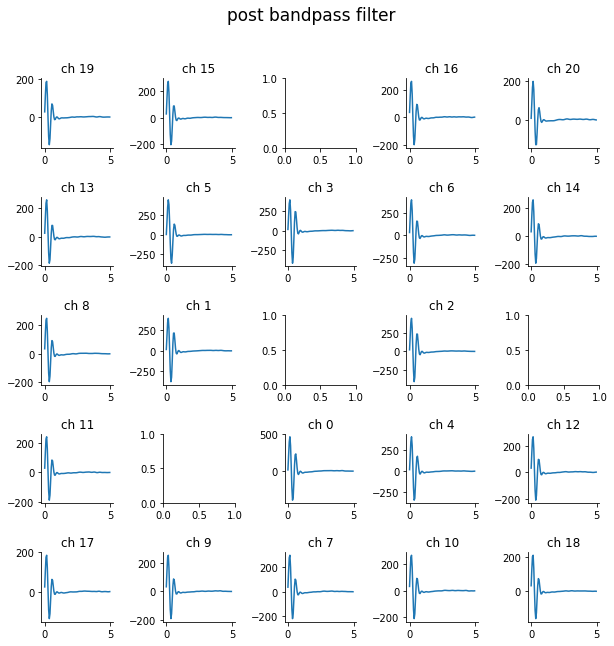

In [29]:
assay3.disp_filtered_on_mea(sp_pattern=-1, frange=np.s_[:100], trange=[0])

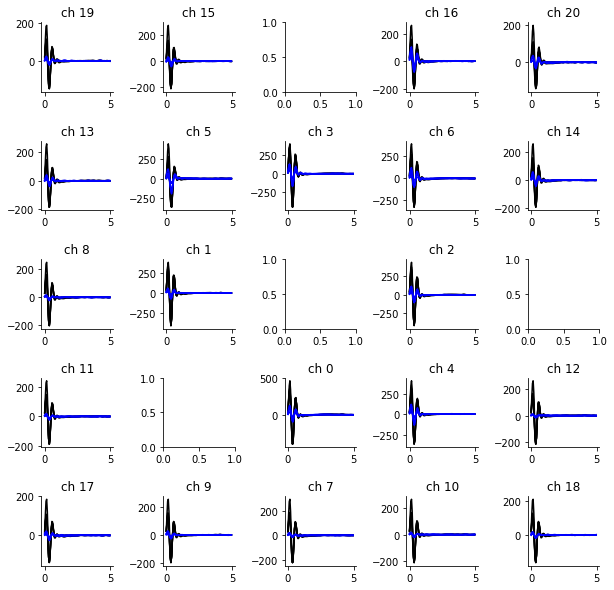

In [30]:
assay3.disp_beforeafter_all(sp_pattern=-1, frange=np.s_[:100], trange=None, yrange=None)

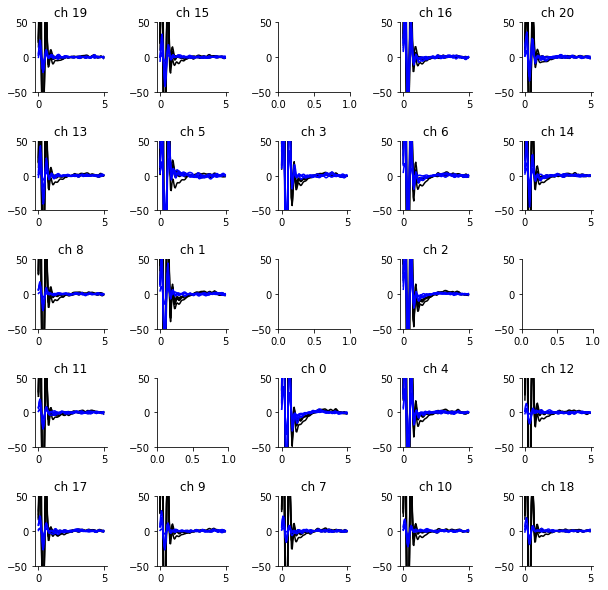

In [31]:
assay3.disp_beforeafter_all(sp_pattern=-1, frange=np.s_[:100], trange=None, yrange=[-50,50])

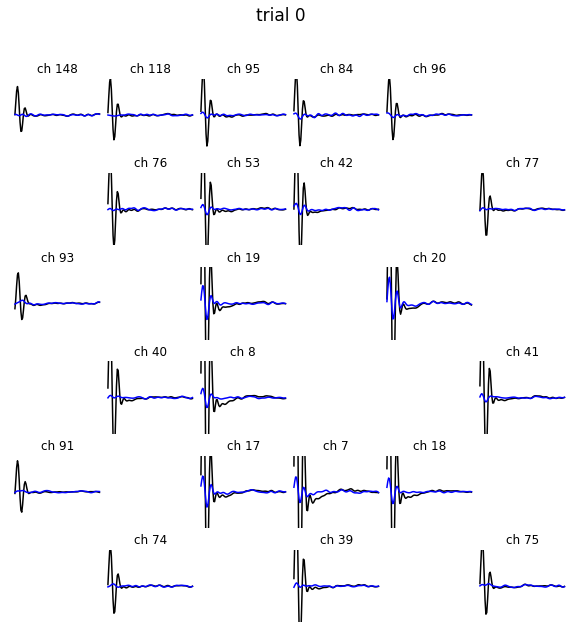

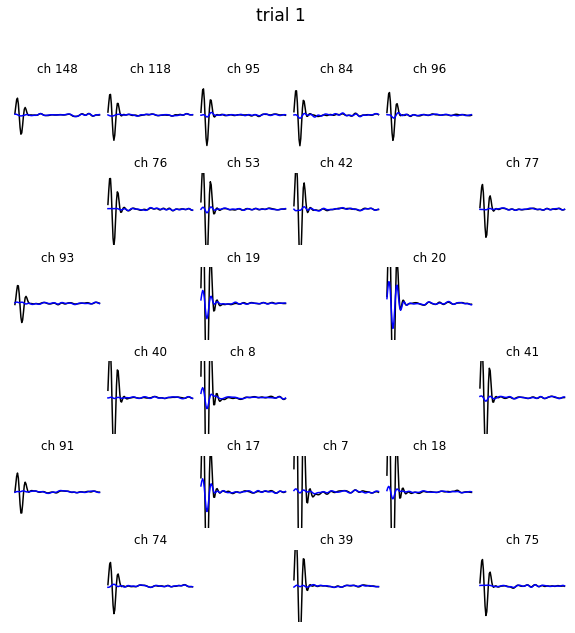

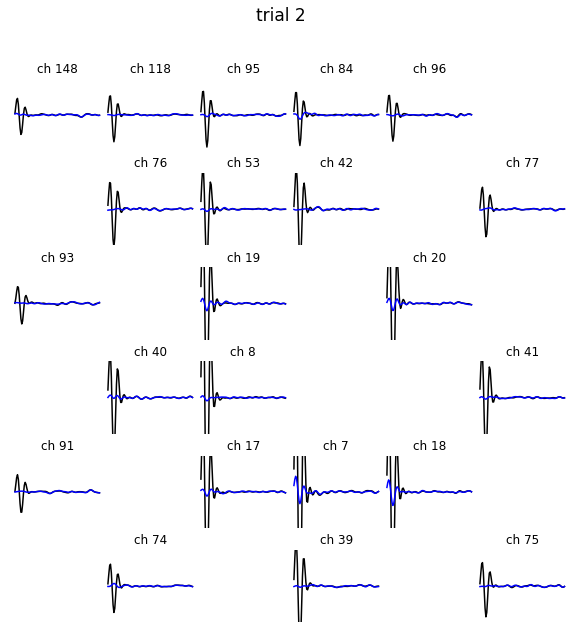

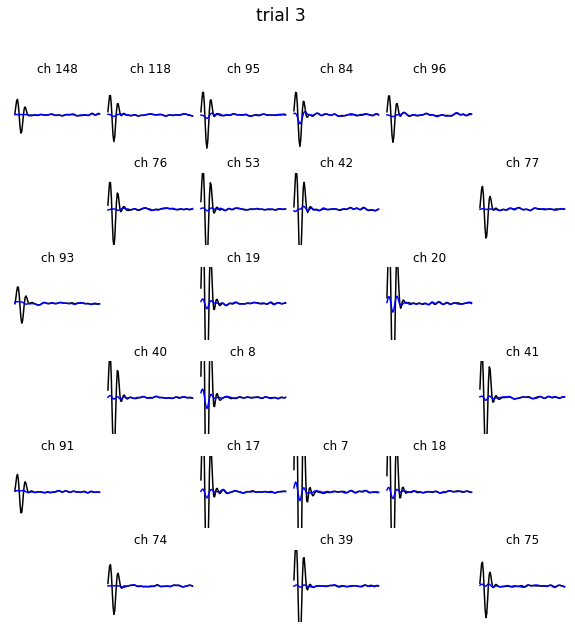

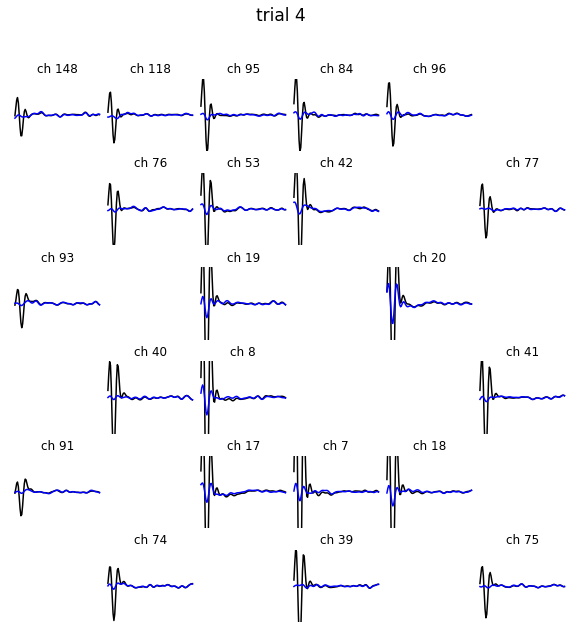

In [32]:
for t in range(5):
    assay3.disp_beforeafter_all(sp_pattern=(2,(6, 6),None), yrange=[-50,50],
                            show_spine=False, hspace=0.3, wspace=0, frange=np.s_[:100], trange=t, title='trial {}'.format(t))

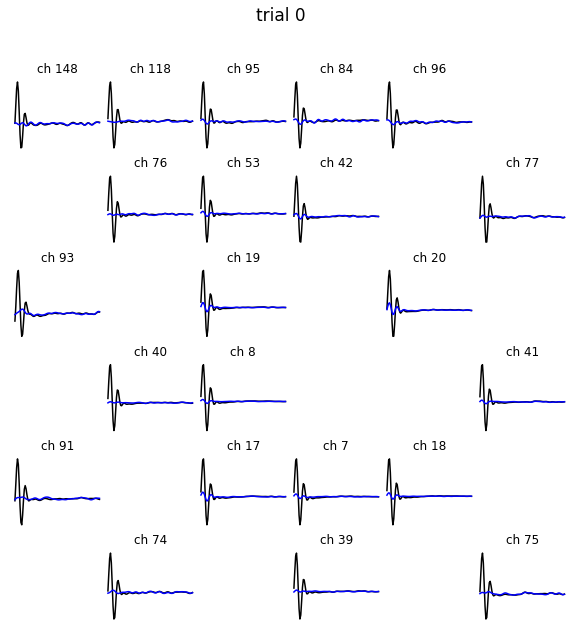

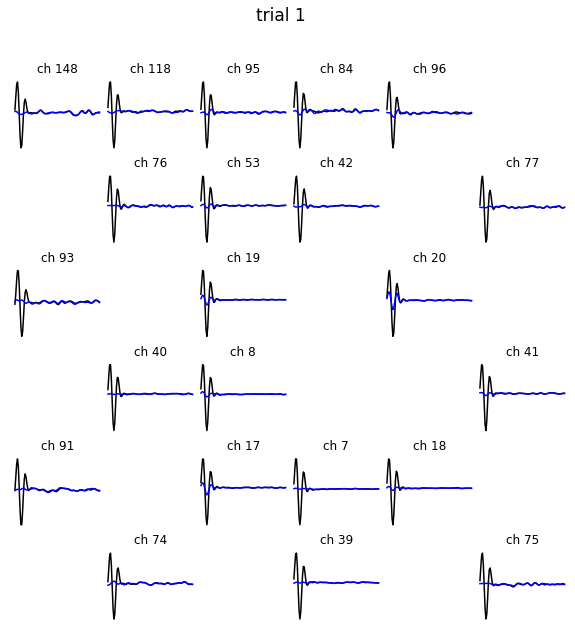

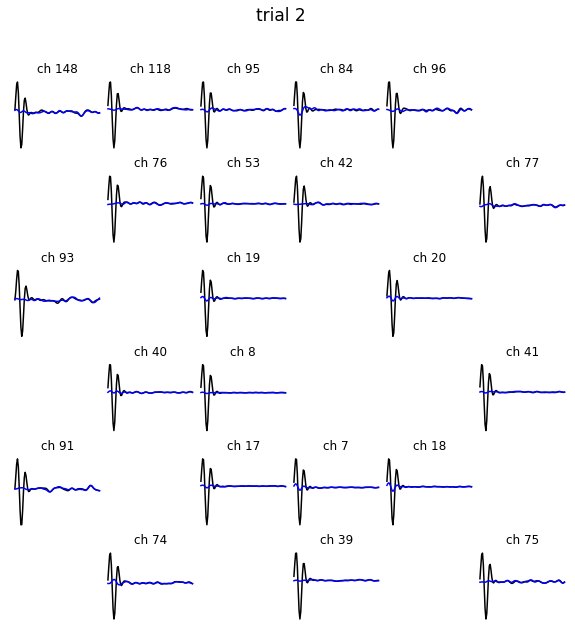

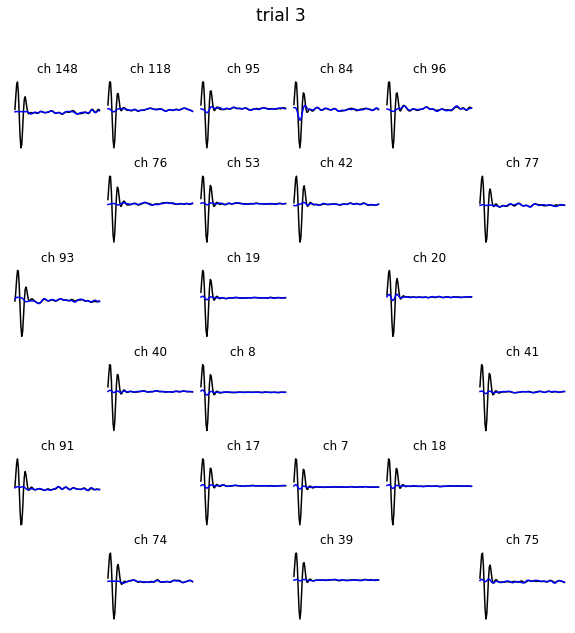

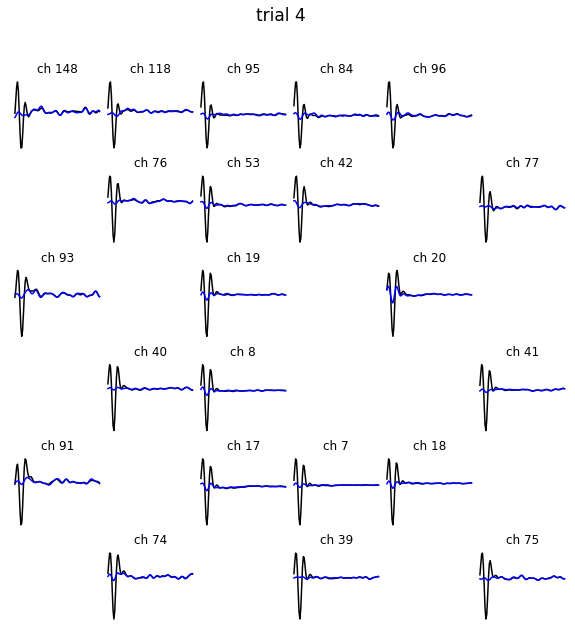

In [33]:
for t in range(5):
    assay3.disp_beforeafter_all(sp_pattern=(2,(6, 6),None), yrange=None,
                            show_spine=False, hspace=0.3, wspace=0, frange=np.s_[:100], trange=t, title='trial {}'.format(t))

## スプライン補間

In [34]:
from maxone_code.spikedetect import BandPassFilter,HighPassFilter

bpfs = {
    'BPF3000': BandPassFilter(lowcut=250, highcut=3000, order=4),
    'BPF5000': BandPassFilter(lowcut=250, highcut=5000, order=4),
    'BPF7500': BandPassFilter(lowcut=250, highcut=7500, order=4),
    'HPF': HighPassFilter(lowcut=250,order=4),
    }

In [35]:
assay_list={}
for name,bpf in bpfs.items():
    assay=ArtifactAssay(path,lookforframe=100)
    assay.bpf=bpf
    assay.loaddata()
    assay.make_resample()
    start_frame=0
    stop_frame=13
    sel=np.s_[start_frame:stop_frame+1]
    assay.cleanArtifact(sel, 20, isResample=True)
    assay_list[name]=assay

In [36]:
assay.data_resampled.shape

(5, 443, 100)

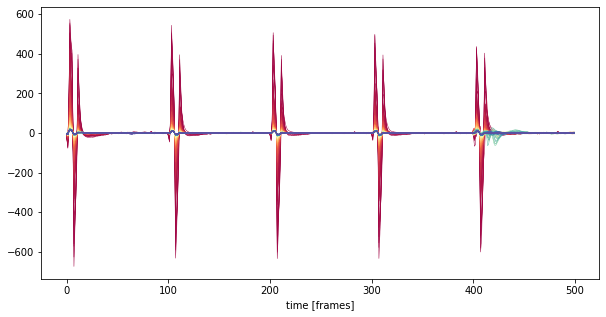

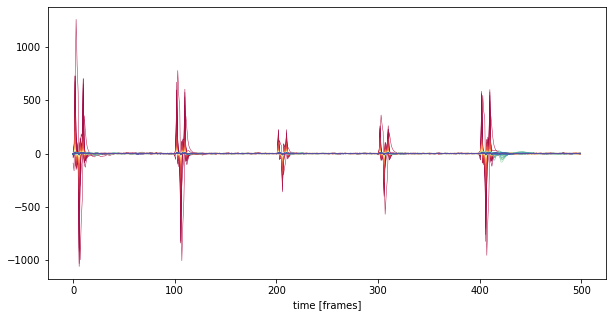

In [37]:
assay=assay_list['HPF']
assay.disp_data(assay.data_resampled, frange=np.s_[:100], trange=None, yrange=None)
assay.disp_data(assay.data_all_cleaned, frange=np.s_[:100], trange=None, yrange=None)

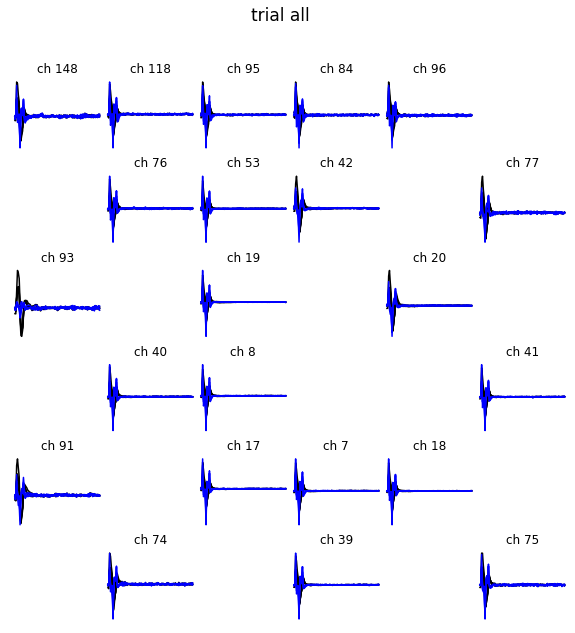

In [40]:

assay.disp_beforeafter_all(sp_pattern=(2,(6, 6),None), yrange=None,
                        show_spine=False, hspace=0.3, wspace=0, frange=np.s_[:100], trange=None, title='trial all'.format(t))

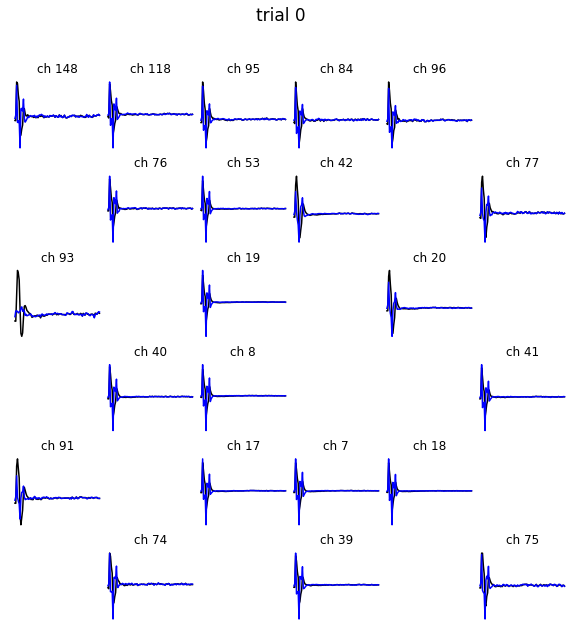

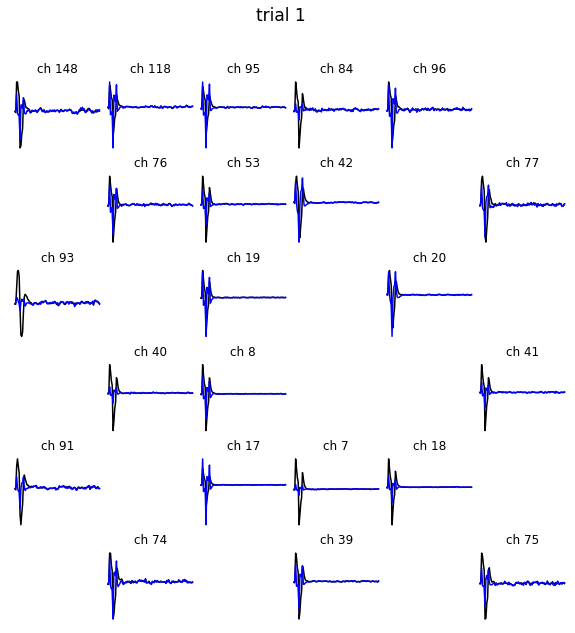

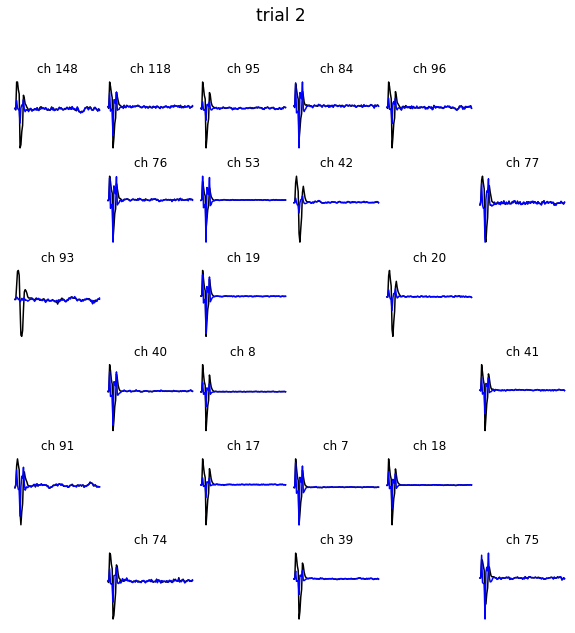

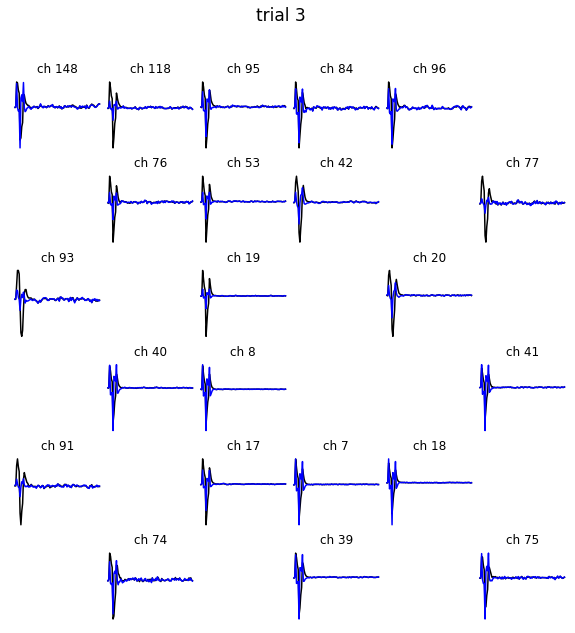

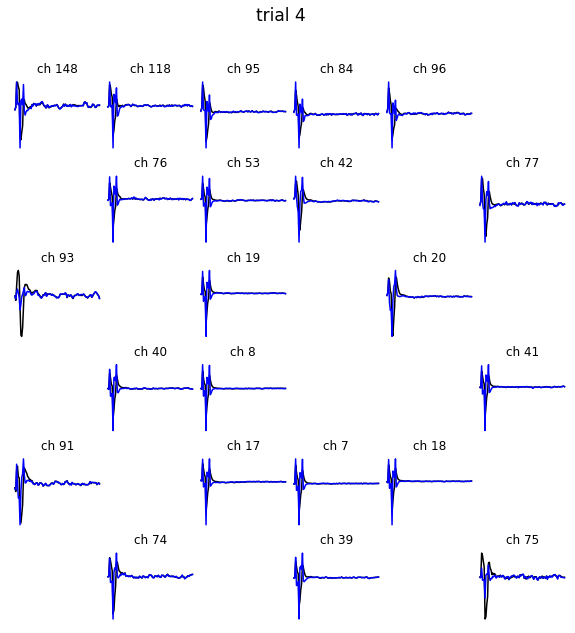

In [38]:
for t in range(5):
    assay.disp_beforeafter_all(sp_pattern=(2,(6, 6),None), yrange=None,
                            show_spine=False, hspace=0.3, wspace=0, frange=np.s_[:100], trange=t, title='trial {}'.format(t))